In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

from tqdm import trange, tqdm

from collections import defaultdict, Counter
from itertools import combinations

In [2]:
def read_snap(edge_file, com_file, prefix=""):
    edges = pd.read_csv(prefix+edge_file, sep='\t', comment="#")
    coms = []
    with open(prefix+com_file, "r") as infile:
        for line in infile:
            x = line[:-1]  # drop trailing newline
            x = x.split('\t')
            coms.append(frozenset([int(y) for y in x])) ## map to 0-based

    g = ig.Graph.DataFrame(edges, directed=False)

    c = [set() for _ in range(g.vcount())]
    for i, com in enumerate(coms):
        for v in com:
            c[v].add(i)
    c = [frozenset(i) for i in c] 
    g.vs["comms"] = c

    # Vertex list is not continugous, drop degree 0 vertices
    g = g.subgraph(np.arange(g.vcount())[np.array(g.degree()) > 0])  

    # Drop some vars to free up memory
    del edges

    return g, c


def read_abcdoo(edge_file, com_file, prefix=""):
    ## read edges, build graph
    fn = prefix+edge_file
    Edges = pd.read_csv(fn, sep='\t', header=None)-1
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = prefix+com_file
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            coms = [int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]  # map to 0-based
            try:
                coms.remove(0)  # Community 0 is outliers
            except ValueError:
                pass
            L.append(tuple(coms)) 
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G

In [3]:
## DBLP graph
dblp_g, dblp_coms = read_snap("com-dblp.ungraph.txt", "com-dblp.all.cmty.txt", "../../SNAP/")
abcdoo_d2_g = read_abcdoo("abcdoo_dblp_d2_edge.dat", "abcdoo_dblp_d2_com.dat", "../../ABCDGraphGenerator.jl/utils/")

print(f"DBLP has {dblp_g.vcount()} vertices.")
print(f"DBLP has {dblp_g.ecount()} edges.")
print(f"DBLP has {len(dblp_coms)} communities.")

DBLP has 317080 vertices.
DBLP has 1049865 edges.
DBLP has 425957 communities.


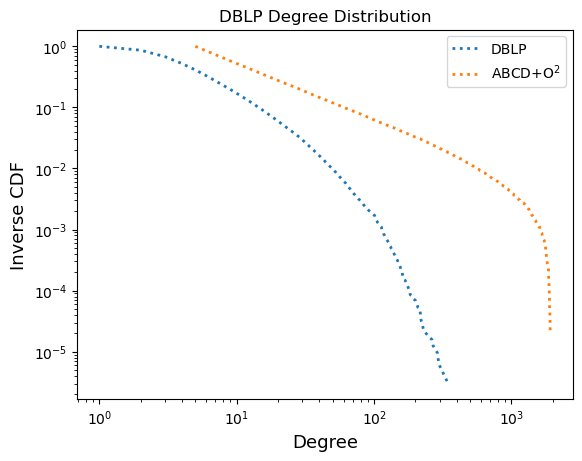

In [6]:
fig, ax = plt.subplots()

options = [dblp_g, abcdoo_d2_g]
names = ["DBLP", r"ABCD+O$^2$"]
for g, name in zip(options, names):
    degrees = g.degree()
    X = powerlaw.Fit(degrees, xmin=np.min(degrees))
    #X.power_law.plot_ccdf(ax=ax, linestyle="-", label=name)
    X.plot_ccdf(ax=ax, linewidth=2, original_data=False, linestyle=":", label=name)

ax.set_title("DBLP Degree Distribution")
ax.legend()
ax.set_xlabel("Degree", fontsize=13)
ax.set_ylabel("Inverse CDF", fontsize=13);

In [7]:
## Amazon graph
amazon_g, _ = read_snap("com-amazon.ungraph.txt", "com-amazon.all.dedup.cmty.txt", "../../SNAP/")
abcdoo_d2_g = read_abcdoo("abcdoo_amazon_d2_edge.dat", "abcdoo_amazon_d2_com.dat", "../../ABCDGraphGenerator.jl/utils/")

fig, ax = plt.subplots()

options = [amazon_g, abcdoo_d2_g]
names = ["Amazon", r"ABCD+O$^2$"]
for g, name in zip(options, names):
    degrees = g.degree()
    X = powerlaw.Fit(degrees, xmin=np.min(degrees))
    #X.power_law.plot_ccdf(ax=ax, linestyle="-", label=name)
    X.plot_ccdf(ax=ax, linewidth=2, original_data=False, linestyle=":", label=name)

ax.set_title("Amazon Degree Distribution")
ax.legend()
ax.set_xlabel("Degree", fontsize=13)
ax.set_ylabel("Inverse CDF", fontsize=13);

FileNotFoundError: [Errno 2] No such file or directory: '../../ABCDGraphGenerator.jl/utils/abcdoo_amazon_d2_edge.dat'

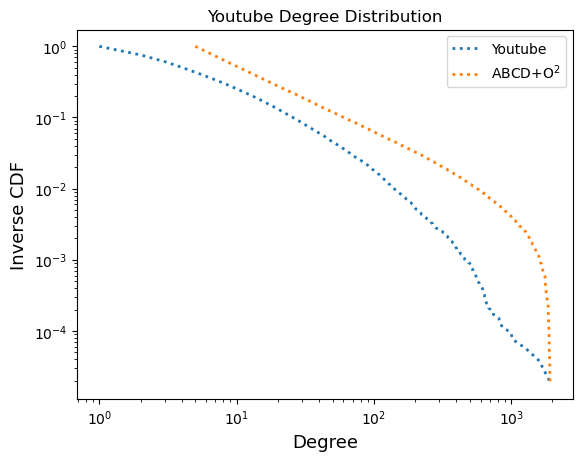

In [8]:
## Youtube graph
youtube_g, _ = read_snap("com-youtube.ungraph.txt", "com-youtube.all.cmty.txt", "../../SNAP/")
# Drop outliers
is_outlier = np.array([len(comms) == 0 for comms in youtube_g.vs["comms"]])
youtube_g = youtube_g.subgraph(np.argwhere(~is_outlier).reshape(-1))
abcdoo_d2_g = read_abcdoo("abcdoo_youtube_nooutliers_d2_edge.dat", "abcdoo_youtube_nooutliers_d2_com.dat", "../../ABCDGraphGenerator.jl/utils/")

fig, ax = plt.subplots()

options = [youtube_g, abcdoo_d2_g]
names = ["Youtube", r"ABCD+O$^2$"]
for g, name in zip(options, names):
    degrees = g.degree()
    X = powerlaw.Fit(degrees, xmin=np.min(degrees))
    #X.power_law.plot_ccdf(ax=ax, linestyle="-", label=name)
    X.plot_ccdf(ax=ax, linewidth=2, original_data=False, linestyle=":", label=name)

ax.set_title("Youtube Degree Distribution")
ax.legend()
ax.set_xlabel("Degree", fontsize=13)
ax.set_ylabel("Inverse CDF", fontsize=13);